#Introduction
##1. Objectif
Ce Notebook est dédié à la réalisation d'une Analyse de Clustering sur l'ensemble de données pour l'Optimisation des campagnes marketing. Les objectifs principaux sont les suivants:
1. Découvrir la structure sous-jacente des données en regroupant les observations aux caractéristiques similaires en différents segments (clusters)
2. Utiliser les résultats du Clustering pour créer une nouvelle variable (new feature) – l'étiquette de cluster – afin d'améliorer la performance des futurs modèles d'Apprentissage Supervisé (Supervised Learning Models).

##2. Aperçu des Étapes
1. Prétraitement des données: Gestion des valeurs manquantes, codage des variables catégorielles et surtout mise à l'échelle des données pour garantir le bon fonctionnement des algorithmes de distance.
2. Réduction de Dimension (Dimensionality Reduction)	Application de l'ACP (Analyse en Composantes Principales) pour réduire le nombre de caractéristiques tout en conservant une grande partie de la variance, ce qui accélère les calculs et facilite la visualisation des clusters.
3. Analyse de ClusteringImplémentation de l'algorithme K-Means. Utilisation de la Méthode du Coude (Elbow Method) et du Score de Silhouette pour déterminer le nombre optimal de clusters ($K$).
4. Évaluation et Attribution d'Étiquettes	Attribution des étiquettes de cluster aux données originales. Réalisation du Profilage des Clusters (Cluster Profiling) en comparant les statistiques descriptives entre les clusters pour en comprendre les implications.
5. Préparation du Modèle et Enregistrement	Exportation du DataFrame final, enrichi de la nouvelle colonne d'étiquettes de cluster, prêt pour la phase de construction et d'entraînement du modèle prédictif.

#Importer des bibliothèques et des ensembles de données

In [ ]:
import pandas as pd
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
from scipy.spatial.distance import cdist
from math import pi
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report


In [ ]:
df=pd.read_csv('/content/Camp_Market_Clean_2025.csv', sep=';')

In [ ]:
df

,ID,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,...,Age,Tenure,TotalMnt,TotalPurchases,AcceptedCmpTotal,Children,Is_Parent,Anciennete_mois,NumWebPurchasesMonth,Taux_conversion_web
0,5524,Graduation,Single,58138.0,0,0,58,635,88,546,...,68,4502,1617,25,0,0,0,147.9,0.054091,0.77
1,2174,Graduation,Single,46344.0,1,1,38,11,1,6,...,71,3952,27,6,0,2,1,129.8,0.007704,0.15
2,4141,Graduation,Together,71613.0,0,0,26,426,49,127,...,60,4151,776,21,0,0,0,136.4,0.058651,1.47
3,6182,Graduation,Together,26646.0,1,0,26,11,4,20,...,41,3978,53,8,0,1,1,130.7,0.015302,0.26
4,5324,PhD,Married,58293.0,1,0,94,173,43,118,...,44,4000,422,19,0,1,1,131.4,0.038052,0.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013,8080,Graduation,Single,26816.0,0,0,50,5,1,6,...,39,4520,22,4,0,0,0,148.5,0.000000,0.00
2014,10870,Graduation,Married,61223.0,0,1,46,709,43,182,...,58,4220,1341,18,0,1,1,138.6,0.064935,1.30
2015,7270,Graduation,Divorced,56981.0,0,0,91,908,48,217,...,44,3994,1241,19,1,0,0,131.2,0.015244,0.25
2016,8235,Master,Together,69245.0,0,1,8,428,30,214,...,69,3995,843,23,0,1,1,131.2,0.045732,1.52


#Prétraitement des données

##Visualiser la distribution de chaque variable, ce qui est essentiel pour :

1. Comprendre la forme des données (symétrie, asymétrie).

2. Identifier d'éventuelles valeurs aberrantes (outliers) ou des anomalies.

3. Confirmer si les étapes de nettoyage et de normalisation (scaling) ont été efficaces avant de passer au clustering.

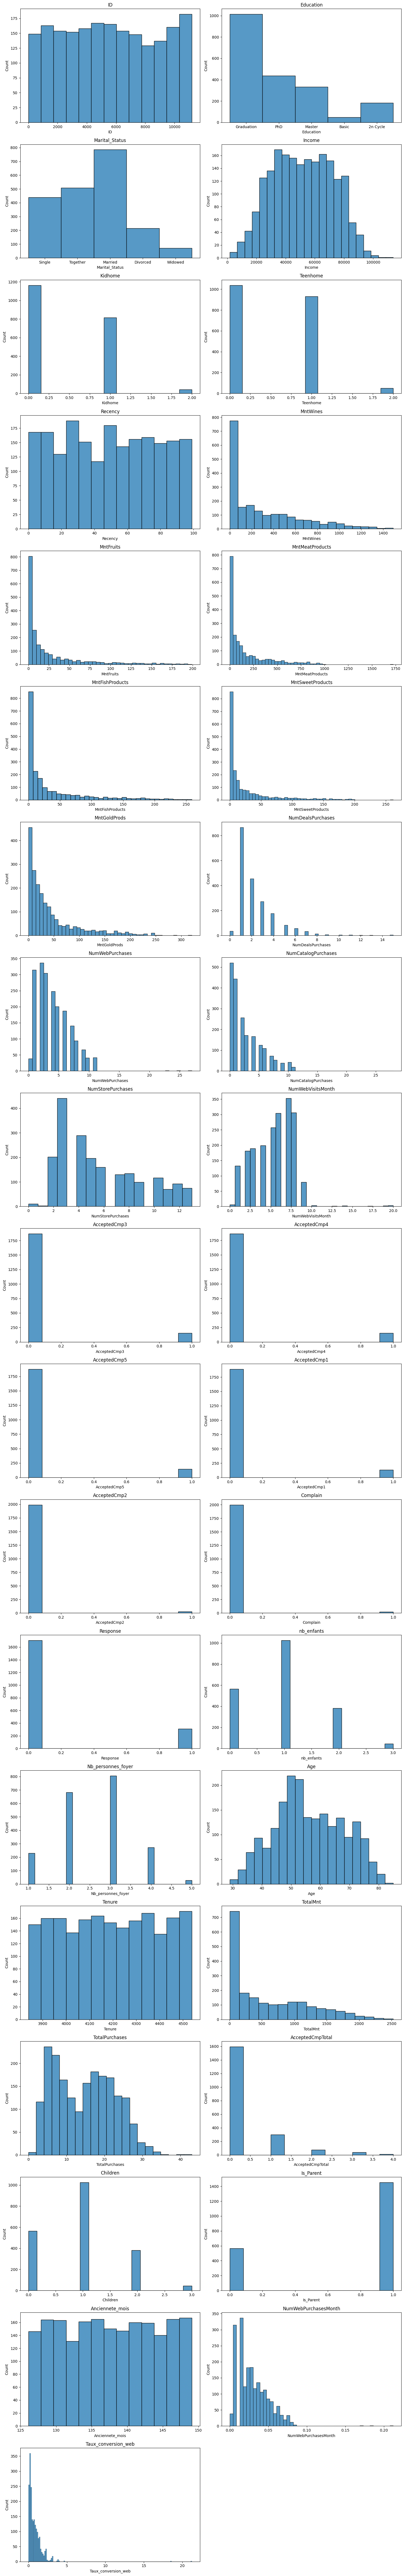

In [ ]:
num_cols=len(df.columns)
num_rows=num_cols // 2 if num_cols % 2 == 0 else num_cols // 2+ 1
plt.figure(figsize=(15,num_rows*5))
for i, col in enumerate(df.columns):
  plt.subplot(num_rows, 2, i+1)
  sns.histplot(df[col].dropna())
  plt.title(col)
plt.tight_layout()
plt.show()

## Supprimer les colonnes indésirables

---



In [ ]:
df_cluster=df.drop(['ID', 'Teenhome', 'Kidhome', 'Nb_personnes_foyer', 'NumWebPurchasesMonth', 'Taux_conversion_web','nb_enfants', 'Anciennete_mois', 'Is_Parent', 'AcceptedCmpTotal'], axis=1)

In [ ]:
df_cluster

,Education,Marital_Status,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Tenure,TotalMnt,TotalPurchases,Children
0,Graduation,Single,58138.0,58,635,88,546,172,88,88,...,0,0,0,0,1,68,4502,1617,25,0
1,Graduation,Single,46344.0,38,11,1,6,2,1,6,...,0,0,0,0,0,71,3952,27,6,2
2,Graduation,Together,71613.0,26,426,49,127,111,21,42,...,0,0,0,0,0,60,4151,776,21,0
3,Graduation,Together,26646.0,26,11,4,20,10,3,5,...,0,0,0,0,0,41,3978,53,8,1
4,PhD,Married,58293.0,94,173,43,118,46,27,15,...,0,0,0,0,0,44,4000,422,19,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013,Graduation,Single,26816.0,50,5,1,6,3,4,3,...,0,0,0,0,0,39,4520,22,4,0
2014,Graduation,Married,61223.0,46,709,43,182,42,118,247,...,0,0,0,0,0,58,4220,1341,18,1
2015,Graduation,Divorced,56981.0,91,908,48,217,32,12,24,...,0,0,0,0,0,44,3994,1241,19,0
2016,Master,Together,69245.0,8,428,30,214,80,30,61,...,0,0,0,0,0,69,3995,843,23,1


# Utilisez « one hot encoder » pour transformer les valeurs alphabétiques en 0 et 1

In [ ]:
colonnes_a_encoder=['Education', 'Marital_Status']

In [ ]:
df_cluster_encode=pd.get_dummies(df_cluster, columns=colonnes_a_encoder, drop_first=True)

In [ ]:
df_cluster_encode

,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,...,TotalPurchases,Children,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widowed
0,58138.0,58,635,88,546,172,88,88,3,8,...,25,0,False,True,False,False,False,True,False,False
1,46344.0,38,11,1,6,2,1,6,2,1,...,6,2,False,True,False,False,False,True,False,False
2,71613.0,26,426,49,127,111,21,42,1,8,...,21,0,False,True,False,False,False,False,True,False
3,26646.0,26,11,4,20,10,3,5,2,2,...,8,1,False,True,False,False,False,False,True,False
4,58293.0,94,173,43,118,46,27,15,5,5,...,19,1,False,False,False,True,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013,26816.0,50,5,1,6,3,4,3,1,0,...,4,0,False,True,False,False,False,True,False,False
2014,61223.0,46,709,43,182,42,118,247,2,9,...,18,1,False,True,False,False,True,False,False,False
2015,56981.0,91,908,48,217,32,12,24,1,2,...,19,0,False,True,False,False,False,False,False,False
2016,69245.0,8,428,30,214,80,30,61,2,6,...,23,1,False,False,True,False,False,False,True,False


# Normalisation des colonnes

---



In [ ]:
scaler=StandardScaler()
df_cluster_encode_scaled=scaler.fit_transform(df_cluster_encode)
df_cluster_encode_scaled=pd.DataFrame(df_cluster_encode_scaled, columns=df_cluster_encode.columns)
df_cluster_encode_scaled

,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,...,TotalPurchases,Children,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widowed
0,0.312364,0.314393,0.972808,1.551855,1.728693,2.461566,1.460331,0.859931,0.354539,1.410822,...,1.330189,-1.278897,-0.157752,0.995057,-0.445351,-0.526512,-0.797909,1.893770,-0.580784,-0.189563
1,-0.257070,-0.376536,-0.874724,-0.636997,-0.727691,-0.648641,-0.631954,-0.734122,-0.173865,-1.130852,...,-1.169914,1.402468,-0.157752,0.995057,-0.445351,-0.526512,-0.797909,1.893770,-0.580784,-0.189563
2,0.962959,-0.791093,0.354004,0.570645,-0.177279,1.345550,-0.150969,-0.034294,-0.702269,1.410822,...,0.803852,-1.278897,-0.157752,0.995057,-0.445351,-0.526512,-0.797909,-0.528047,1.721812,-0.189563
3,-1.208121,-0.791093,-0.874724,-0.561519,-0.664007,-0.502279,-0.583856,-0.753562,-0.173865,-0.767756,...,-0.906746,0.061786,-0.157752,0.995057,-0.445351,-0.526512,-0.797909,-0.528047,1.721812,-0.189563
4,0.319848,1.558066,-0.395076,0.419690,-0.218219,0.156353,-0.006674,-0.559165,1.411346,0.321533,...,0.540683,0.061786,-0.157752,-1.004968,-0.445351,1.899291,1.253276,-0.528047,-0.580784,-0.189563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013,-1.199913,0.038022,-0.892488,-0.636997,-0.727691,-0.630346,-0.559807,-0.792441,-0.702269,-1.493949,...,-1.433083,-1.278897,-0.157752,0.995057,-0.445351,-0.526512,-0.797909,1.893770,-0.580784,-0.189563
2014,0.461313,-0.100164,1.191907,0.419690,0.072908,0.083172,2.181808,3.950840,-0.173865,1.773918,...,0.409098,0.061786,-0.157752,0.995057,-0.445351,-0.526512,1.253276,-0.528047,-0.580784,-0.189563
2015,0.256502,1.454427,1.781104,0.545486,0.232118,-0.099781,-0.367413,-0.384208,-0.702269,-0.767756,...,0.540683,-1.278897,-0.157752,0.995057,-0.445351,-0.526512,-0.797909,-0.528047,-0.580784,-0.189563
2016,0.848628,-1.412930,0.359925,0.092620,0.218471,0.778395,0.065474,0.335060,-0.173865,0.684629,...,1.067020,0.061786,-0.157752,-1.004968,2.245421,-0.526512,-0.797909,-0.528047,1.721812,-0.189563


# Détermination du nombre optimal de clusters ( K ) pour l'algorithme K-Means à l'aide de la Méthode du Coude et du Coefficient de Silhouette.

##Méthode du Coude (Elbow)

In [ ]:
range_k=range(1,11)
sse=[]
for k  in range_k:
  kmeans=KMeans(n_clusters=k, random_state=42, n_init='auto')
  kmeans.fit(df_cluster_encode_scaled)
  sse.append(kmeans.inertia_)


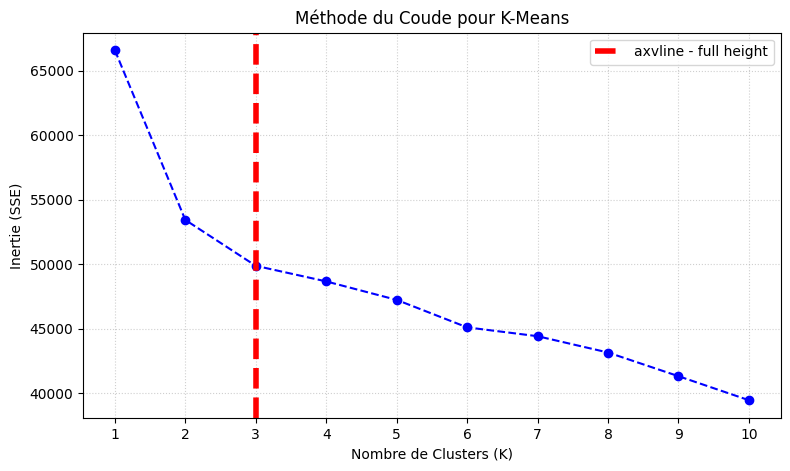

In [ ]:
plt.figure(figsize=(9, 5))
plt.plot(range_k, sse, marker='o', linestyle='--', color='blue')
plt.title('Méthode du Coude pour K-Means')
plt.xlabel('Nombre de Clusters (K)')
plt.ylabel('Inertie (SSE)')
plt.grid(True, linestyle=':', alpha=0.6)
plt.xticks(range_k)
plt.axvline (x = 3, color = "red", label = "axvline - full height",linewidth = 4, linestyle ="--")
plt.legend()
plt.show()

# #Silhouette Score

In [ ]:
range_k_silhouette = range(2, 11)
silhouette_scores = []
for k in range_k_silhouette:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(df_cluster_encode_scaled)
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(df_cluster_encode_scaled, labels)
    silhouette_scores.append(silhouette_avg)

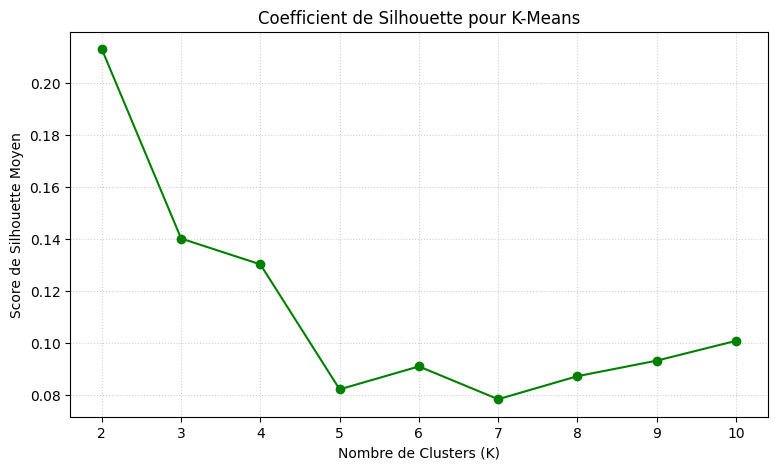

In [ ]:
plt.figure(figsize=(9, 5))
plt.plot(range_k_silhouette, silhouette_scores, marker='o', linestyle='-', color='green')
plt.title('Coefficient de Silhouette pour K-Means')
plt.xlabel('Nombre de Clusters (K)')
plt.ylabel('Score de Silhouette Moyen')
plt.grid(True, linestyle=':', alpha=0.6)
plt.xticks(range_k_silhouette)
plt.show()

In [ ]:
best_k_silhouette = range_k_silhouette[np.argmax(silhouette_scores)]
best_k_silhouette

2

D'après la méthode du coude et le coefficient de silhouette, nous avons k = 2 ou k = 3. Nous avons testé avec k = 2 et k = 3. Finalement, nous avons choisi k = 3, car le résultat est meilleur.

In [ ]:
kmean_final=KMeans(n_clusters=3, random_state=42, n_init='auto')
kmean_final.fit(df_cluster_encode_scaled)
df['Cluster']=kmean_final.labels_


#PCA/ACP - Réduction de Dimension : Analyse en Composantes Principales

L'Analyse en Composantes Principales (ACP) est une technique de réduction de dimension non supervisée. Elle est appliquée ici pour deux raisons principales : simplifier la visualisation des clusters et améliorer l'efficacité de l'algorithme K-Means en éliminant le bruit des données.

In [ ]:
pca = PCA(n_components=2)
df_cluster_encode_pca = pca.fit_transform(df_cluster_encode_scaled)
df_cluster_encode_pca = pd.DataFrame(df_cluster_encode_pca, columns=['PC1', 'PC2'])
df_cluster_encode_pca['Cluster'] = kmean_final.labels_

Après avoir entraîné l'ACP, le Cercle de Corrélation nous permet de visualiser et d'interpréter la relation entre les variables d'origine et les nouvelles Composantes Principales (CP).

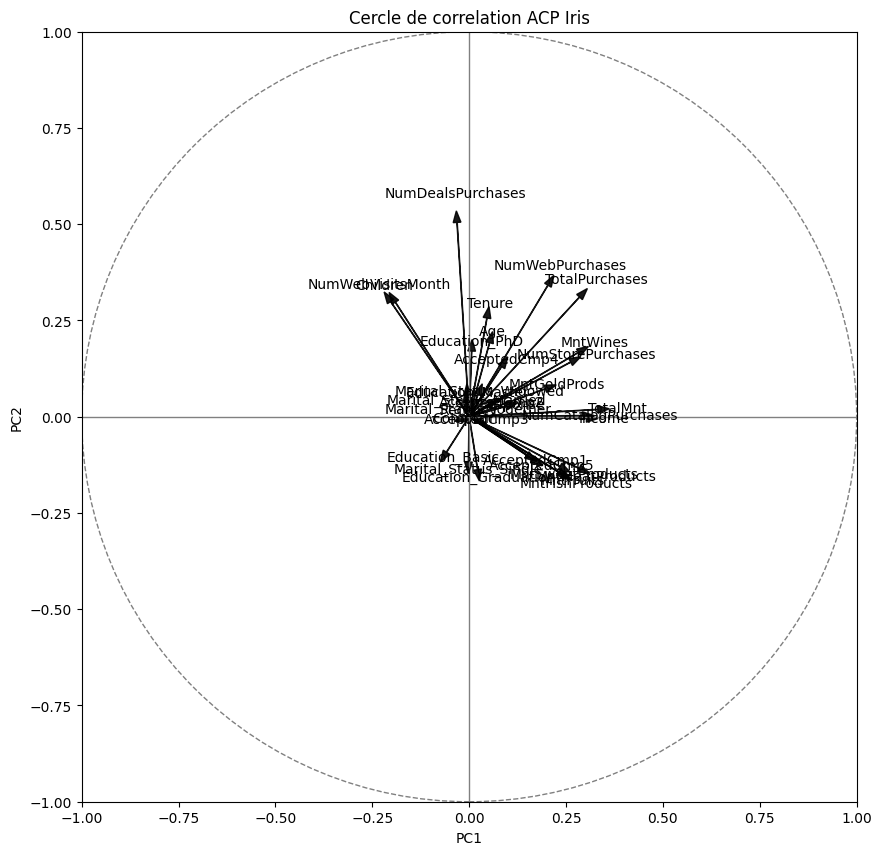

In [ ]:
coeff= np.transpose(pca.components_[0:2, :])
n=coeff.shape[0]
xs= np.array([1, 0])
ys= np.array([0, 1])
plt.figure(figsize=(10, 10))
for i in range(n):
  plt.arrow(0, 0, coeff[i,0], coeff[i, 1], color='k', alpha=0.9, head_width=0.02)
  plt.text(coeff[i, 0]*1.15, coeff[i, 1]*1.15, df_cluster_encode_scaled.columns[i], color='k', ha='center', va='center' )
circle=plt.Circle((0, 0), radius=1, color='grey', fill=False, linestyle='--')
plt.gca().add_artist(circle)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.axhline(y=0, color='gray', linewidth=1)
plt.axvline(x=0, color='gray', linewidth=1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Cercle de correlation ACP Iris')
plt.show()

#Visualisation des Clusters ($K=3$) sur le Plan Factoriel ACP

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


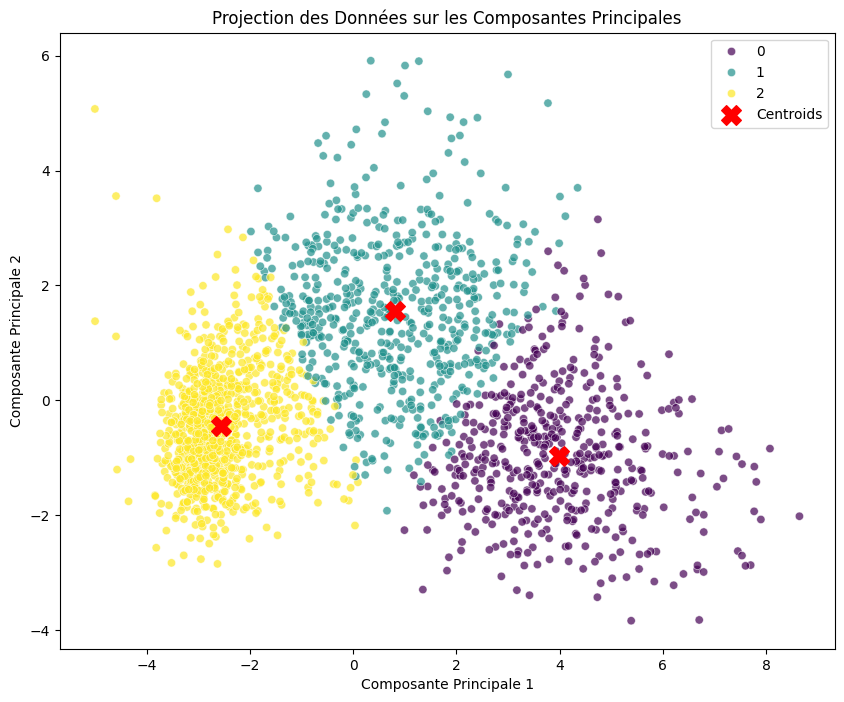

In [ ]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_cluster_encode_pca, x='PC1', y='PC2', hue='Cluster', palette='viridis', alpha=0.7)
plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.title('Projection des Données sur les Composantes Principales')
centroids=pca.transform(kmean_final.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', s=200, c='red', label='Centroids')
plt.legend()
plt.show()

Ce graphique représente les données dans l'espace réduit des deux premières Composantes Principales (PC1 et PC2), avec les points colorés selon l'étiquette de cluster attribuée par l'algorithme K-Means (avec $K=3$).

#Profilage Détaillé et Interprétation des Clusters

In [ ]:
µRFM=['Recency', 'TotalMnt', 'TotalPurchase']

In [ ]:
mnt_by_product=['MntWines', 'MntFruits','MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']

In [ ]:
num_purchase=['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']

In [ ]:
num_purchase_without_store=['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases']

In [ ]:
accepted_cmp=['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']

In [ ]:
variable_categorielle=[ 'Marital_Status']

In [ ]:
variable_categorielle2=[ 'Education']

In [ ]:
variables_numeriques=['Recency', 'TotalMnt', 'TotalPurchases', 'Income', 'Age']

##RFM + Variables Numeriques Cluster Profiling (RFM - Recency, Frequency, Monetary)

In [ ]:
segment_summary_numerique = df.groupby('Cluster')[variables_numeriques].mean()

In [ ]:
print(segment_summary_numerique.to_markdown())

|   Cluster |   Recency |   TotalMnt |   TotalPurchases |   Income |     Age |
|----------:|----------:|-----------:|-----------------:|---------:|--------:|
|         0 |   49.3012 |   1422.77  |          20.7684 |  76806.8 | 56.5041 |
|         1 |   48.3242 |    748.326 |          21.1921 |  57915.9 | 59.9314 |
|         2 |   49.0465 |    100.094 |           7.9831 |  34868.1 | 53.5871 |


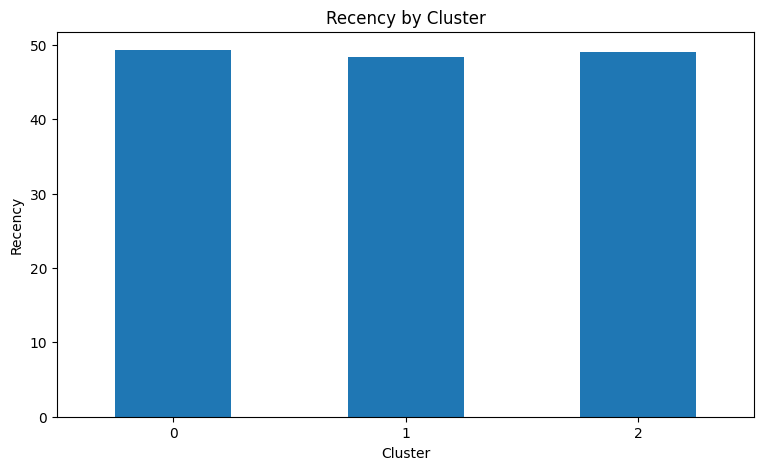

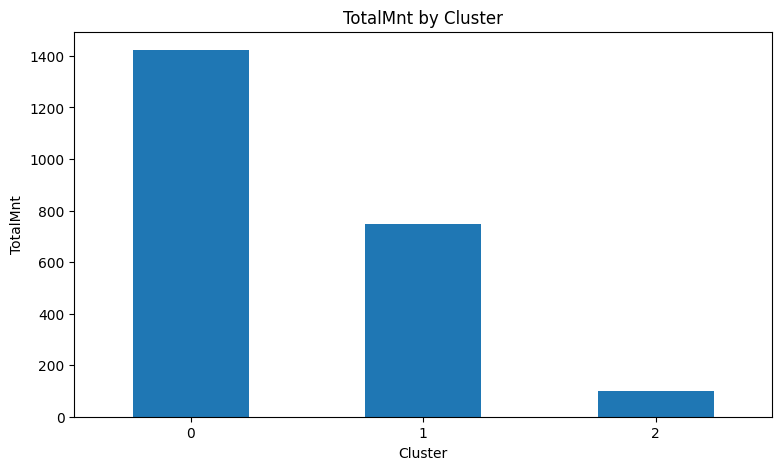

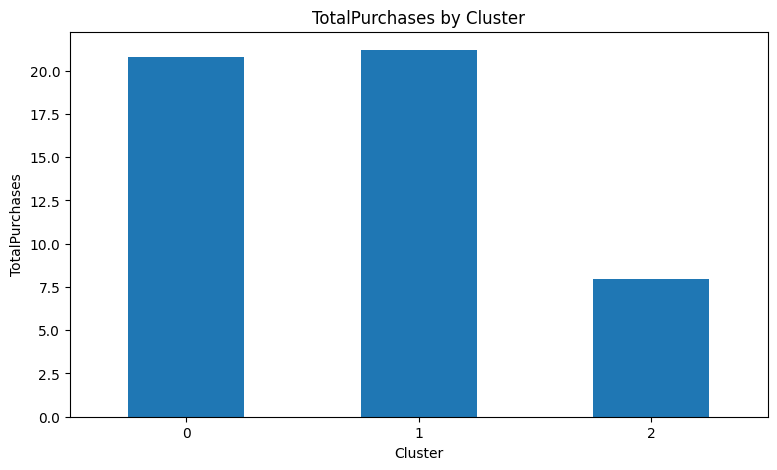

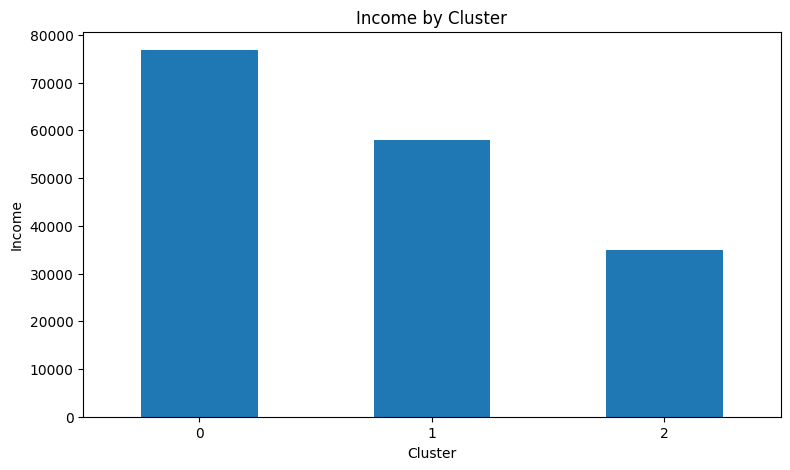

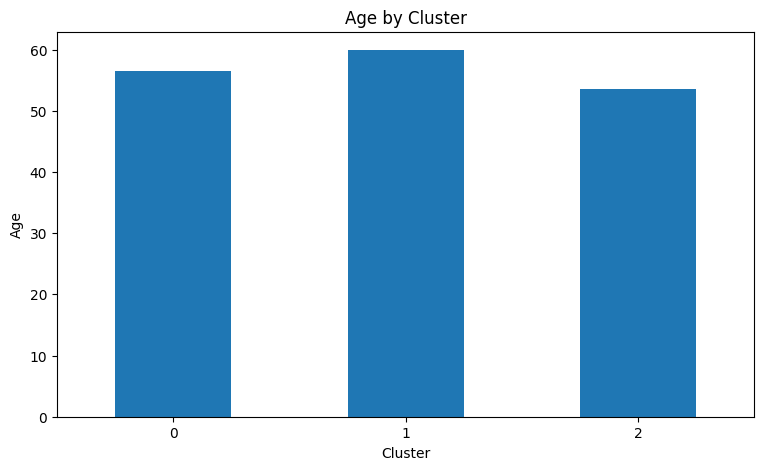

In [ ]:
for col in variables_numeriques:
    plt.figure(figsize=(9, 5))
    segment_summary_numerique[col].plot(kind='bar')
    plt.xlabel('Cluster')
    plt.ylabel(col)
    plt.title(f'{col} by Cluster')
    plt.xticks(rotation=0)
    plt.show()

Basé sur cette analyse, nous pouvons renommer les segments pour plus de clarté dans la modélisation et les communications marketing :

Cluster 0:Haute Valeur / Prestige

Cluster 1: Valeur Moyenne / Fréquent

Cluster 2: Faible Valeur / Budget

Ces étiquettes de cluster seront encodées et utilisées comme une variable prédictive puissante dans le modèle d'apprentissage supervisé, permettant de prédire le comportement ou la valeur future du client en fonction de son segment actuel.

#Marital Cluster Profiling

In [ ]:
segment_summary_cat = df.groupby('Cluster')[variable_categorielle].value_counts(normalize=True).mul(100).unstack(fill_value=0)

In [ ]:
print(segment_summary_cat.to_markdown())

|   Cluster |   Divorced |   Married |   Single |   Together |   Widowed |
|----------:|-----------:|----------:|---------:|-----------:|----------:|
|         0 |    9.01639 |   36.6803 |  24.5902 |    25      |   4.71311 |
|         1 |   13.2075  |   40.6518 |  16.4666 |    25.3859 |   4.28816 |
|         2 |    9.82049 |   38.9652 |  23.6536 |    25.2376 |   2.32313 |


In [ ]:
counts_bruts = df.groupby('Cluster')[variable_categorielle].value_counts()
total_par_categorie = df[variable_categorielle].value_counts()
segment_distribution_normale = counts_bruts.div(total_par_categorie)
segment_summary_normale = segment_distribution_normale.mul(100).unstack(fill_value=0)

In [ ]:
print(segment_summary_normale.to_markdown())

|   Cluster |   Divorced |   Married |   Single |   Together |   Widowed |
|----------:|-----------:|----------:|---------:|-----------:|----------:|
|         0 |    20.5607 |   22.8025 |  27.2727 |    23.9686 |   32.8571 |
|         1 |    35.9813 |   30.1911 |  21.8182 |    29.0766 |   35.7143 |
|         2 |    43.4579 |   47.0064 |  50.9091 |    46.9548 |   31.4286 |


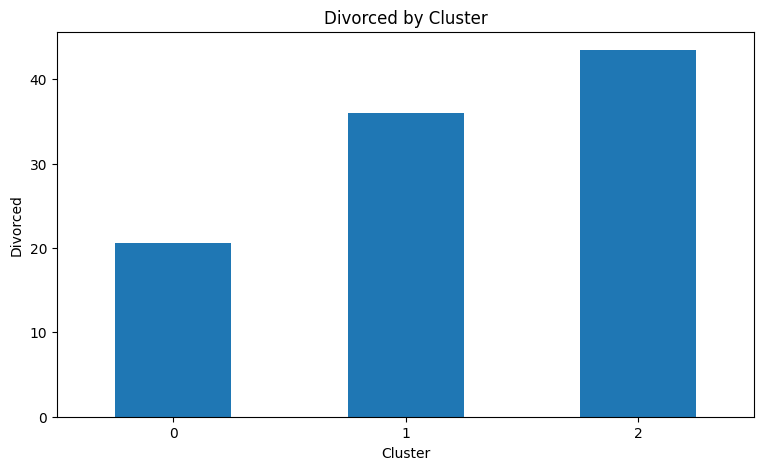

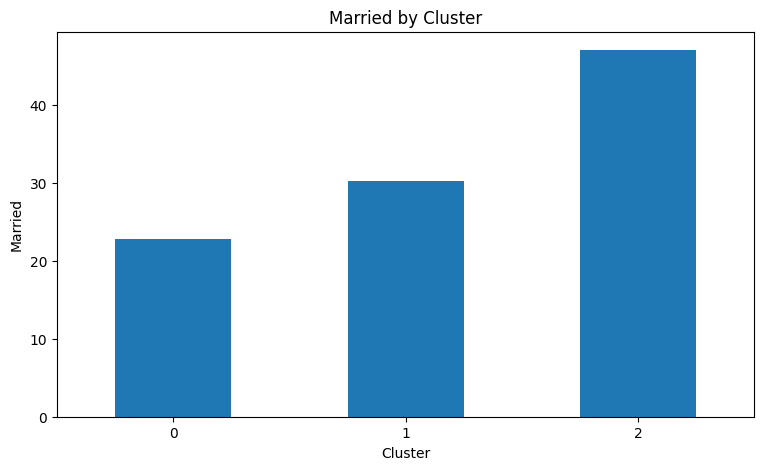

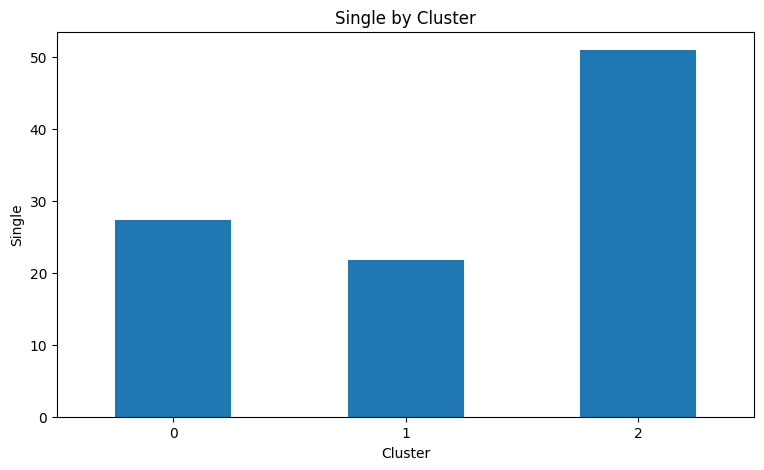

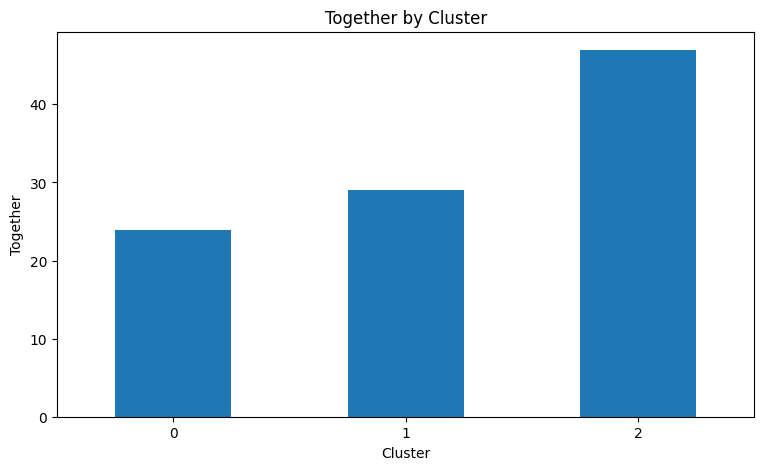

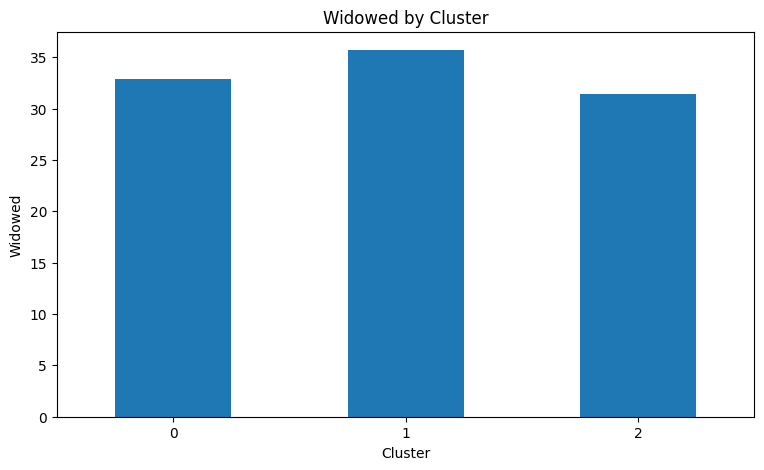

In [ ]:
for col in segment_summary_normale.columns:
    plt.figure(figsize=(9, 5))
    segment_summary_normale[col].plot(kind='bar')
    plt.xlabel('Cluster')
    plt.ylabel(col)
    plt.title(f'{col} by Cluster')
    plt.xticks(rotation=0)
    plt.show()

L'analyse de la répartition du statut marital dans les trois clusters met en évidence des distinctions nettes qui complètent l'analyse du revenu et de l'âge :

Cluster 0 (Haute Valeur) : Se distingue par la plus forte proportion de personnes veuves (32.86%). Ce profil, souvent associé à une population plus âgée ayant un patrimoine accumulé, est cohérent avec leur revenu et leurs dépenses les plus élevés.

Cluster 1 (Valeur Moyenne) : Présente une surreprésentation des statuts divorcés et veufs, suggérant une population avec des structures familiales ou des étapes de vie variées, mais dont les dépenses sont intermédiaires.

Cluster 2 (Faible Valeur) : Est clairement dominé par les statuts célibataire (50.91%) et marié (47.01%). Ce profil est typique d'une population plus jeune (cohérent avec l'âge moyen le plus faible) ou de ménages ayant un revenu plus faible, ce qui explique leur faible niveau de dépenses.

##Education Cluster Profiling

In [ ]:
segment_summary_cat2=df.groupby('Cluster')[variable_categorielle2].value_counts(normalize=True).mul(100).unstack(fill_value=0)

In [ ]:
print(segment_summary_cat2.to_markdown())

|   Cluster |   2n Cycle |    Basic |   Graduation |   Master |     PhD |
|----------:|-----------:|---------:|-------------:|---------:|--------:|
|         0 |    9.22131 | 0        |      57.1721 |  14.1393 | 19.4672 |
|         1 |    6.34648 | 0.171527 |      45.9691 |  18.8679 | 28.6449 |
|         2 |   10.6653  | 5.06864  |      49.3136 |  16.3675 | 18.585  |


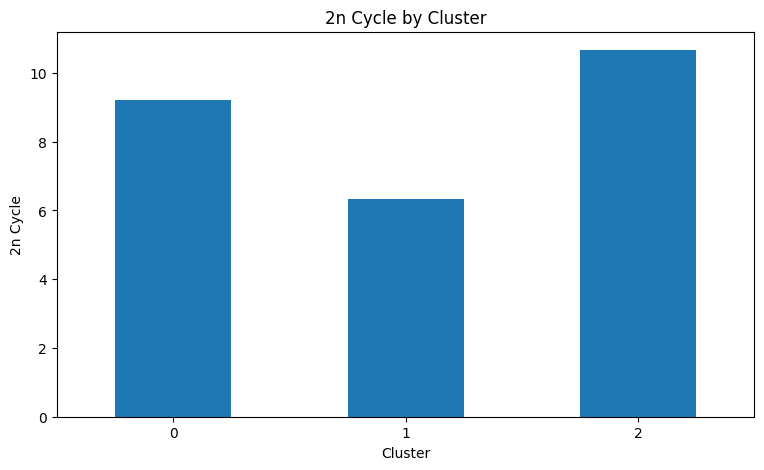

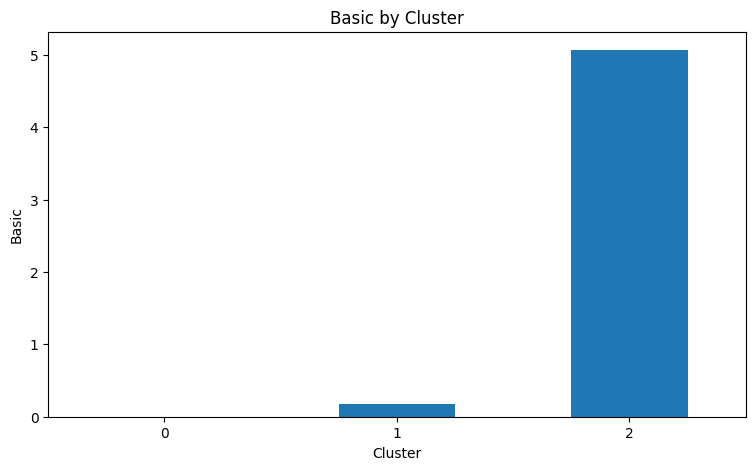

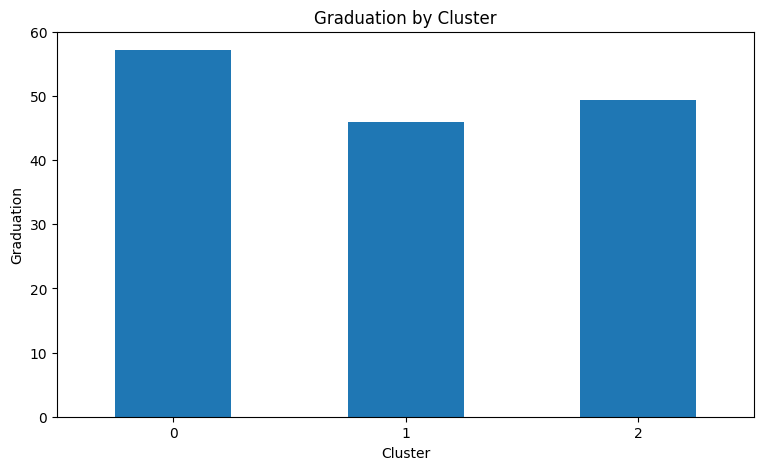

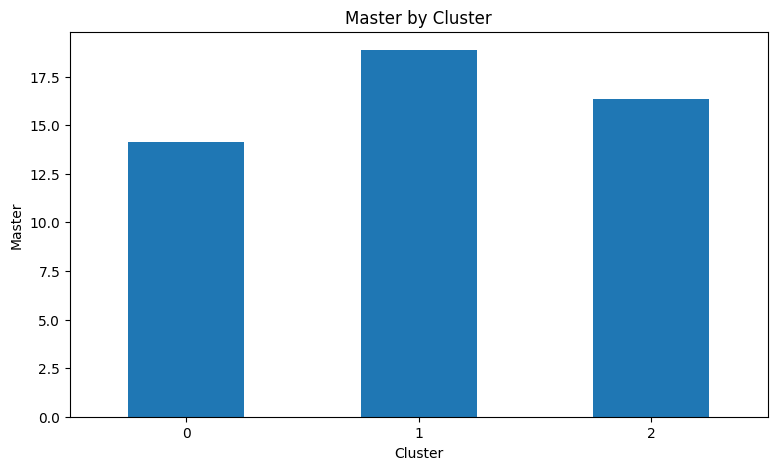

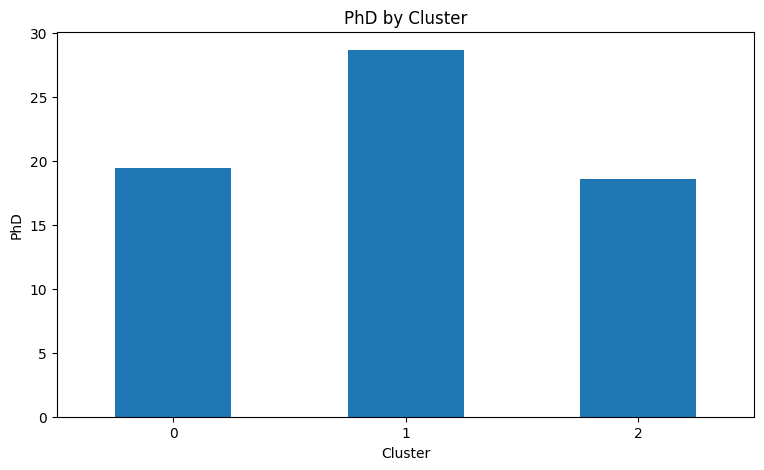

In [ ]:
for col in segment_summary_cat2.columns:
    plt.figure(figsize=(9, 5))
    segment_summary_cat2[col].plot(kind='bar')
    plt.xlabel('Cluster')
    plt.ylabel(col)
    plt.title(f'{col} by Cluster')
    plt.xticks(rotation=0)
    plt.show()

Le profilage des clusters est désormais complet. Les trois segments se distinguent clairement selon des axes thématiques majeurs :
Cluster 0 : Dépenses et Revenu Élevés, Niveau d'Éducation Graduation Dominant.

Cluster 1 : Dépenses et Revenu Moyens/Élevés, Niveau d'Éducation Avancé (PhD/Master) Dominant.

Cluster 2 : Dépenses et Revenu Faibles, Niveau d'Éducation Intermédiaire/Bas Dominant.

##Accept Campagne Cluster Profiling

In [ ]:
segment_summary_cmp=df.groupby('Cluster')[accepted_cmp].sum()

In [ ]:
print(segment_summary_cmp.to_markdown())

|   Cluster |   AcceptedCmp1 |   AcceptedCmp2 |   AcceptedCmp3 |   AcceptedCmp4 |   AcceptedCmp5 |   Response |
|----------:|---------------:|---------------:|---------------:|---------------:|---------------:|-----------:|
|         0 |            115 |             17 |             41 |             65 |            137 |        152 |
|         1 |             16 |              8 |             42 |             78 |              8 |         70 |
|         2 |              1 |              1 |             68 |             12 |              0 |         88 |


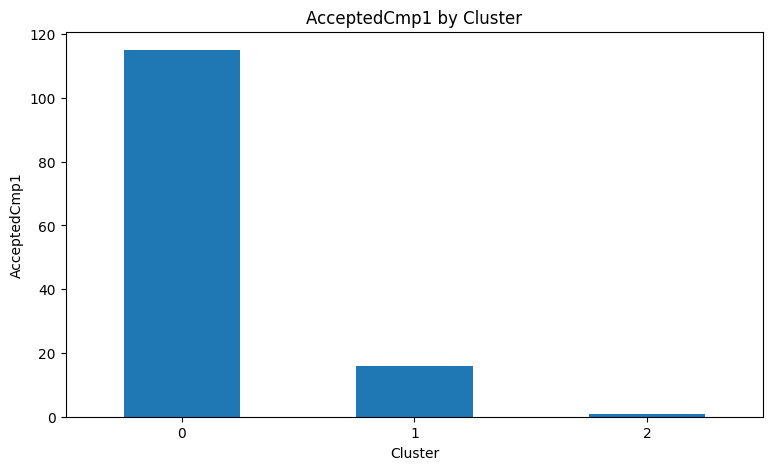

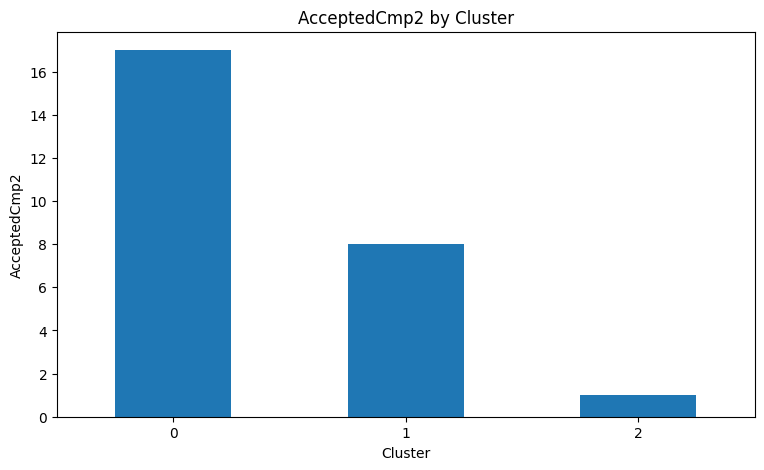

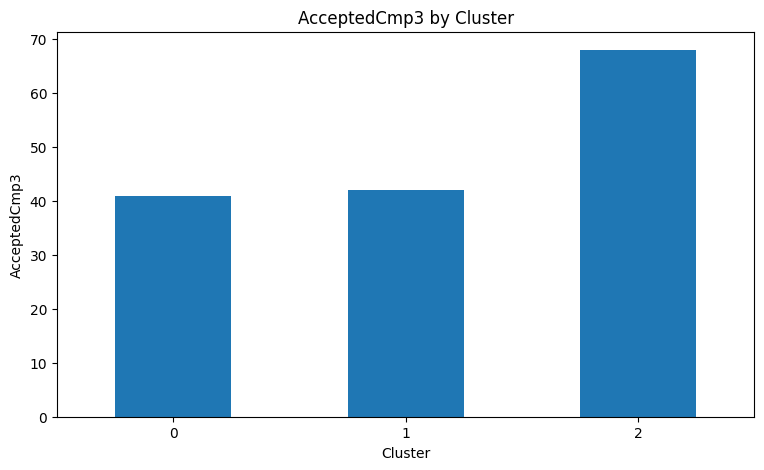

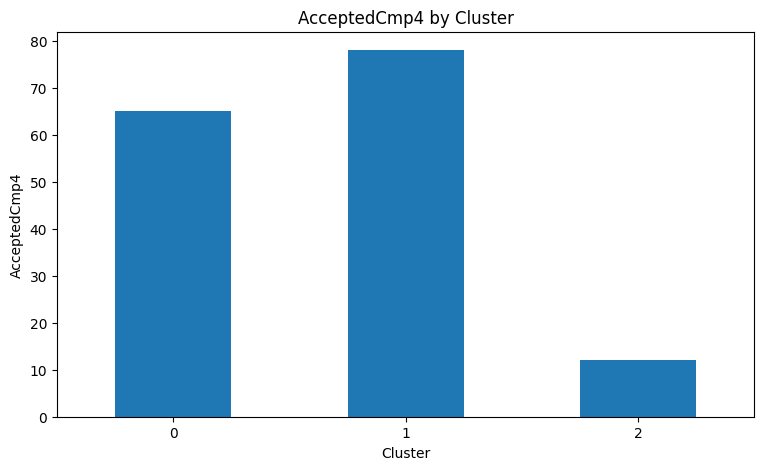

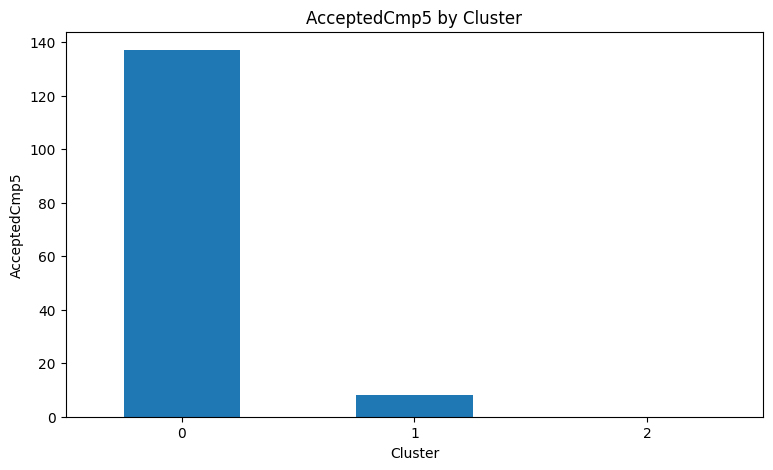

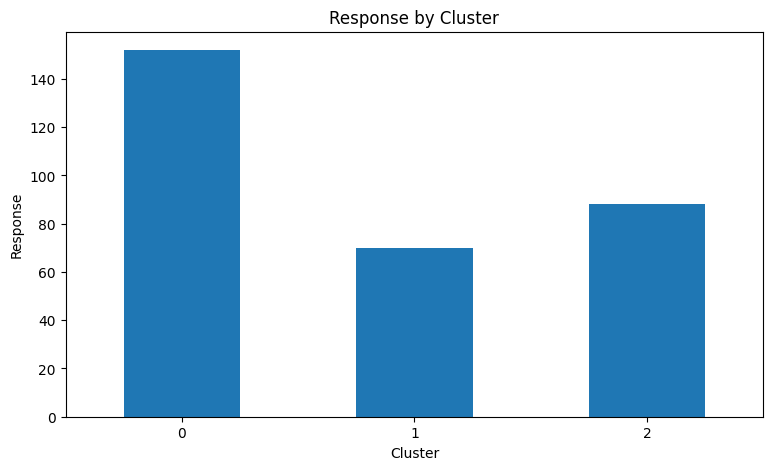

In [ ]:
for col in segment_summary_cmp.columns:
    plt.figure(figsize=(9, 5))
    segment_summary_cmp[col].plot(kind='bar')
    plt.xlabel('Cluster')
    plt.ylabel(col)
    plt.title(f'{col} by Cluster')
    plt.xticks(rotation=0)
    plt.show()

- Cluster 0 (Haute Valeur) : Ce cluster est le plus réactif de loin. Il a le plus grand nombre d'acceptations pour la plupart des campagnes (Cmp1, Cmp2, Cmp5) et le score de Response le plus élevé.

- Cluster 1 (Valeur Moyenne) : Ce cluster se distingue par le plus grand nombre d'acceptations de la Campagne 4.

- Cluster 2 (Faible Valeur) : Ce cluster a la plus faible réactivité générale, mais se distingue par la plus forte acceptation de la Campagne 3.

## Product Cluster Profiling

In [ ]:
segment_summary_prd=df.groupby('Cluster')[mnt_by_product].mean()

In [ ]:
print(segment_summary_prd.to_markdown())

|   Cluster |   MntWines |   MntFruits |   MntMeatProducts |   MntFishProducts |   MntSweetProducts |   MntGoldProds |
|----------:|-----------:|------------:|------------------:|------------------:|-------------------:|---------------:|
|         0 |   632.488  |    68.9098  |          471.539  |          99.918   |           72.8607  |        77.0553 |
|         1 |   459.852  |    25.3482  |          142.333  |          34.3842  |           25.0926  |        61.3156 |
|         2 |    43.9704 |     4.96832 |           23.0634 |           7.15523 |            5.13305 |        15.8036 |


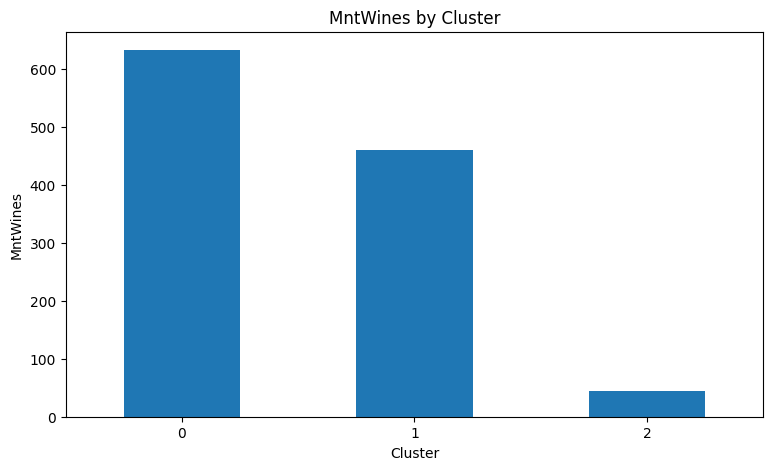

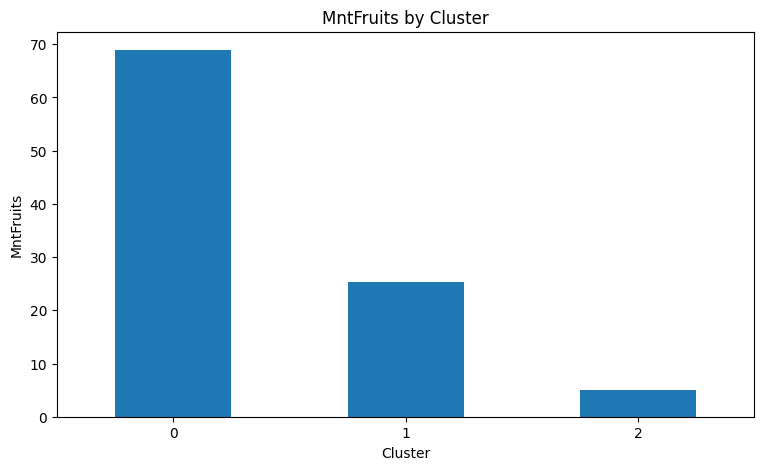

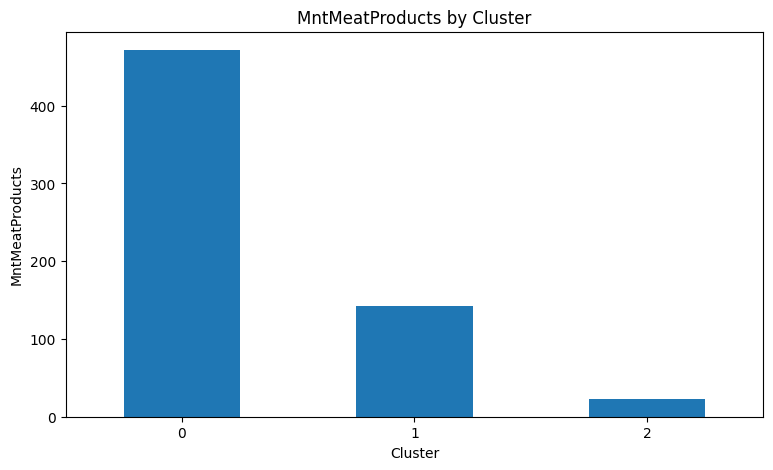

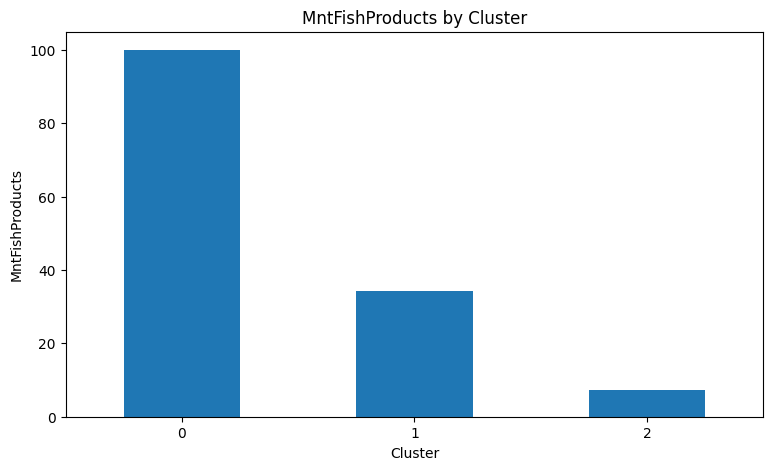

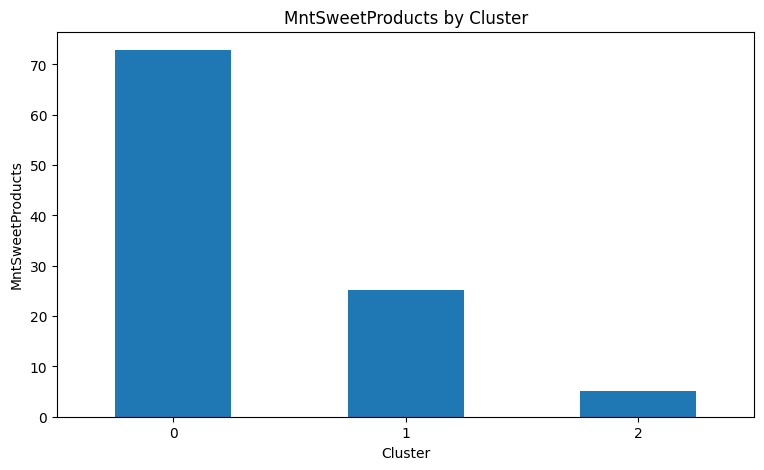

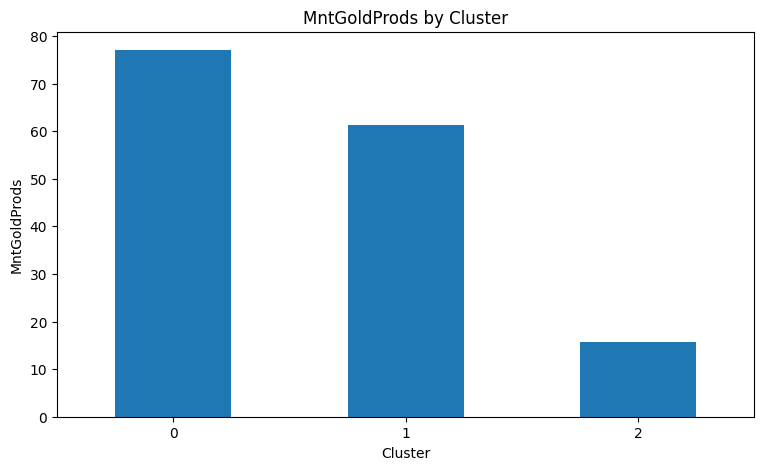

In [ ]:
for col in segment_summary_prd.columns:
    plt.figure(figsize=(9, 5))
    segment_summary_prd[col].plot(kind='bar')
    plt.xlabel('Cluster')
    plt.ylabel(col)
    plt.title(f'{col} by Cluster')
    plt.xticks(rotation=0)
    plt.show()

- Cluster 0 (Haute Valeur / Champions) : Ce segment domine les dépenses dans absolument toutes les catégories. Il achète l'ensemble du catalogue et est clairement le segment 'Premium' qui ne fait pas de compromis sur le choix. Leur préférence est universelle, soulignant leur fort pouvoir d'achat et leur rôle de moteur principal des revenus.

- Cluster 1 (Valeur Moyenne / Amateurs de Vin) : Ce segment a des dépenses beaucoup plus faibles que le Cluster 0, mais montre une forte propension à acheter du Vin (MntWines est sa dépense principale). Les dépenses en Viande (MntMeatProducts) sont également significatives.

-> Stratégie : Ce sont des acheteurs réguliers qui valorisent le Vin et les produits associés (Viande).

- Cluster 2 (Faible Valeur / Budget) : Les dépenses sont minimales et très faibles dans toutes les catégories.

-> Stratégie : Ce segment n'a pas de préférence d'achat claire pour les produits de luxe. Leurs achats sont soit occasionnels, soit limités aux articles de budget (MntGoldProds est proportionnellement faible), ce qui est cohérent avec leur faible revenu.

## Canal Cluster Profiling

In [ ]:
segment_summary_canal = df.groupby('Cluster')[num_purchase].sum()
segment_summary_canal_percentage = segment_summary_canal.apply(lambda x: x / x.sum() * 100, axis=1)

In [ ]:
print("Percentage of purchases by channel within each cluster:")
print(segment_summary_canal_percentage.to_markdown())

Percentage of purchases by channel within each cluster:
|   Cluster |   NumDealsPurchases |   NumWebPurchases |   NumCatalogPurchases |   NumStorePurchases |
|----------:|--------------------:|------------------:|----------------------:|--------------------:|
|         0 |             5.85101 |           24.8841 |              29.186   |             40.0789 |
|         1 |            17.7175  |           30.3926 |              14.7875  |             37.1024 |
|         2 |            25.3704  |           26.7989 |               7.19577 |             40.6349 |


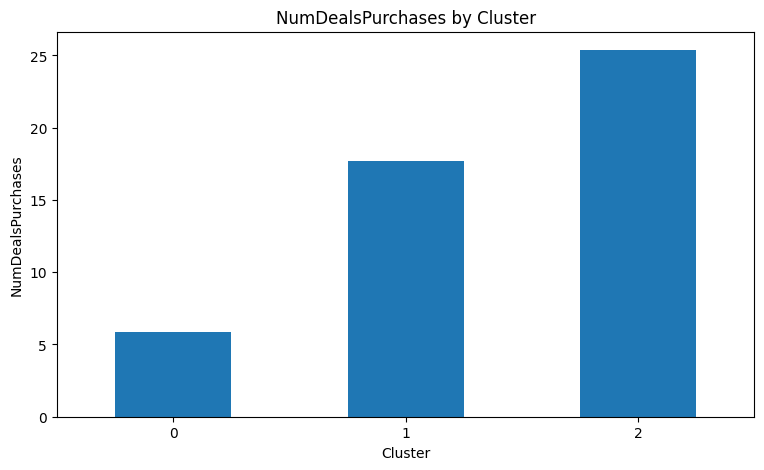

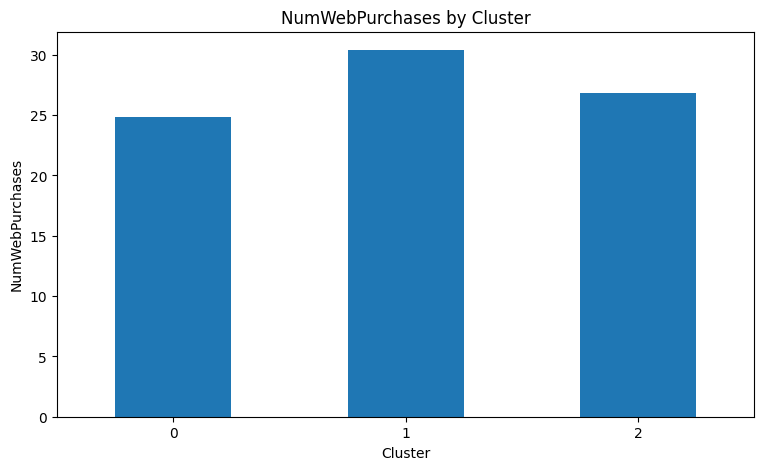

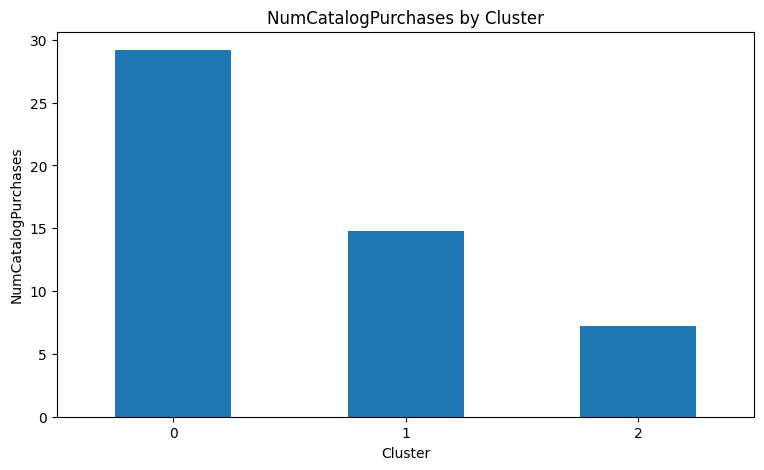

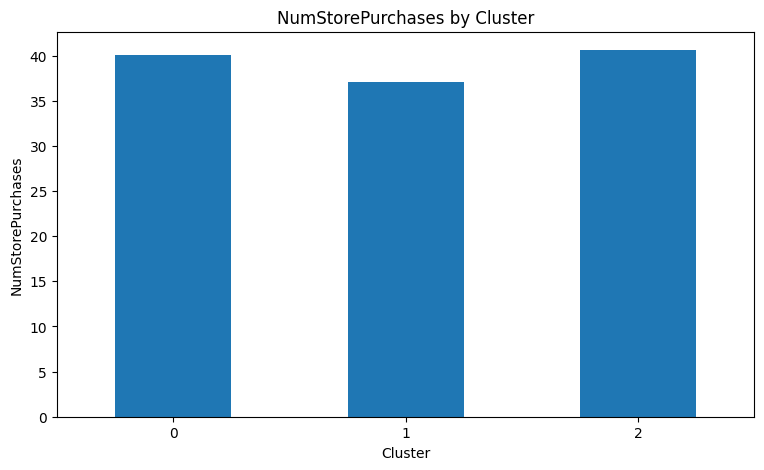

In [ ]:
for col in segment_summary_canal_percentage .columns:
    plt.figure(figsize=(9, 5))
    segment_summary_canal_percentage [col].plot(kind='bar')
    plt.xlabel('Cluster')
    plt.ylabel(col)
    plt.title(f'{col} by Cluster')
    plt.xticks(rotation=0)
    plt.show()

Cluster 0 (Haute Valeur / Champions) :

- Canal Préféré : Ce cluster effectue la plus grande proportion d'achats via Catalogue (29.19%).

Cluster 1 (Valeur Moyenne / Amateurs de Vin) :

- Canal Préféré : Ce segment est le plus orienté vers le Web (30.39%), et préfère les achats en ligne aux catalogues.

Cluster 2 (Faible Valeur / Budget) :

- Canal Préféré : Ce cluster est le plus sensible aux promotions (Deals - 25.37%) et fait la majorité de ses achats en Magasin (40.63%).


## Having Kid Cluster Profiling

In [ ]:
segment_summary_kids=df.groupby('Cluster')[['Children', 'Kidhome', 'Teenhome']].mean()

In [ ]:
print(segment_summary_kids.to_markdown())

|   Cluster |   Children |   Kidhome |   Teenhome |
|----------:|-----------:|----------:|-----------:|
|         0 |   0.196721 | 0.0286885 |   0.168033 |
|         1 |   1.13208  | 0.267581  |   0.864494 |
|         2 |   1.23442  | 0.766631  |   0.467793 |


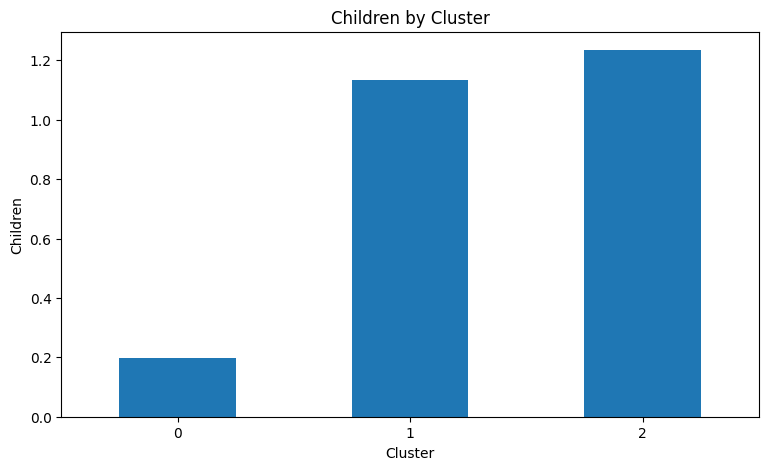

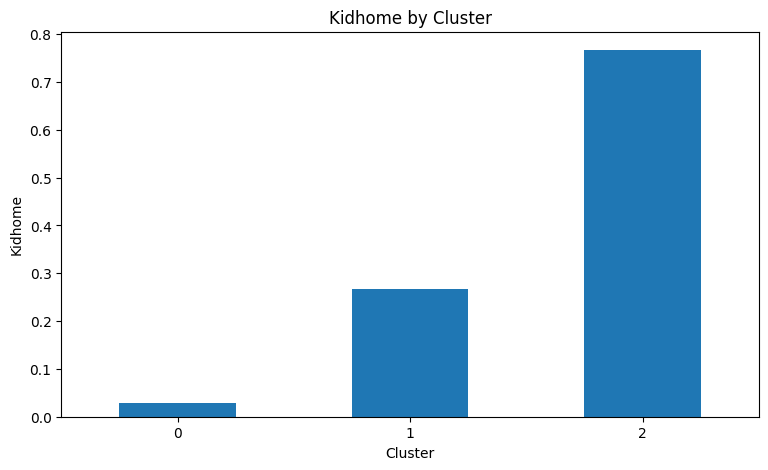

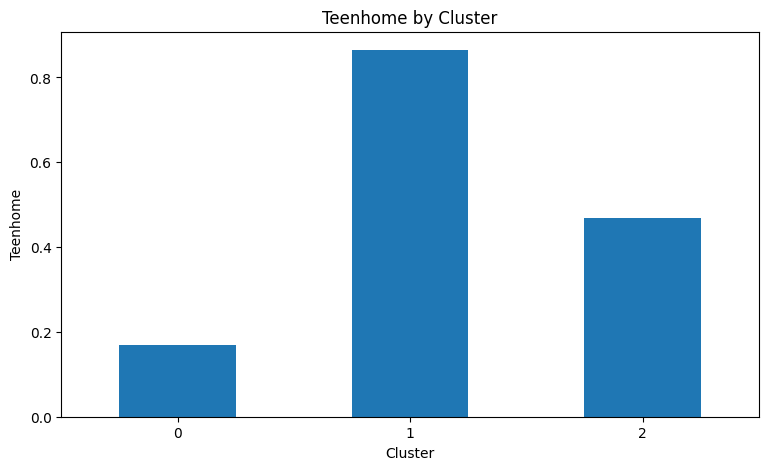

In [ ]:
for col in segment_summary_kids.columns:
    plt.figure(figsize=(9, 5))
    segment_summary_kids[col].plot(kind='bar')
    plt.xlabel('Cluster')
    plt.ylabel(col)
    plt.title(f'{col} by Cluster')
    plt.xticks(rotation=0)
    plt.show()

Cluster 0 (Haute Valeur / Champions): Ce cluster a le nombre total d'enfants le plus bas (seulement $0.197$ en moyenne) et pratiquement aucun enfant en bas âge (Kidhome à $0.029$).                                                     

Cluster 1 (Valeur Moyenne / Amateurs de Vin): Ce cluster est dominé par la présence d'adolescents (Teenhome à $0.864$, le plus haut).

Cluster 2 (Faible Valeur / Budget)Caractéristique Clé : Ce cluster a le nombre total d'enfants le plus élevé (1.234) et la plus forte concentration d'enfants en bas âge (Kidhome à $0.767$).

##Purchase_without_store Cluster Profiling

In [ ]:
segment_summary_purchase_without_store = df.groupby('Cluster')[num_purchase_without_store].sum()
segment_summary_purchase_without_store = segment_summary_purchase_without_store.apply(lambda x: x / x.sum() * 100, axis=1)

In [ ]:
print(segment_summary_purchase_without_store.to_markdown())

|   Cluster |   NumDealsPurchases |   NumWebPurchases |   NumCatalogPurchases |
|----------:|--------------------:|------------------:|----------------------:|
|         0 |             9.76453 |           41.5281 |               48.7074 |
|         1 |            28.1688  |           48.3207 |               23.5105 |
|         2 |            42.7362  |           45.1426 |               12.1212 |


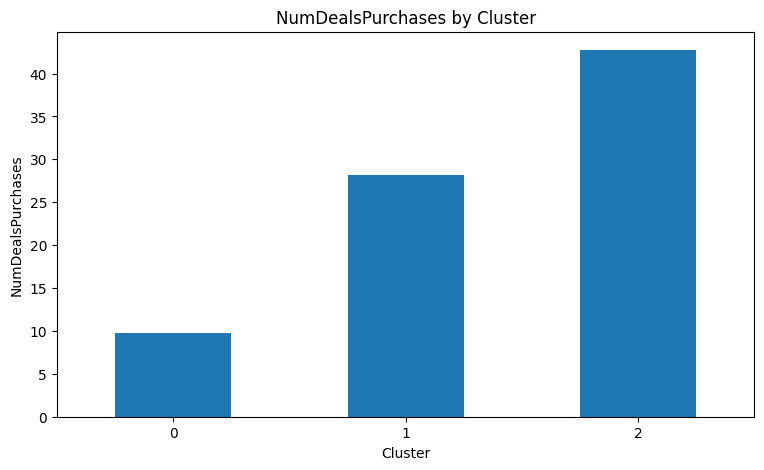

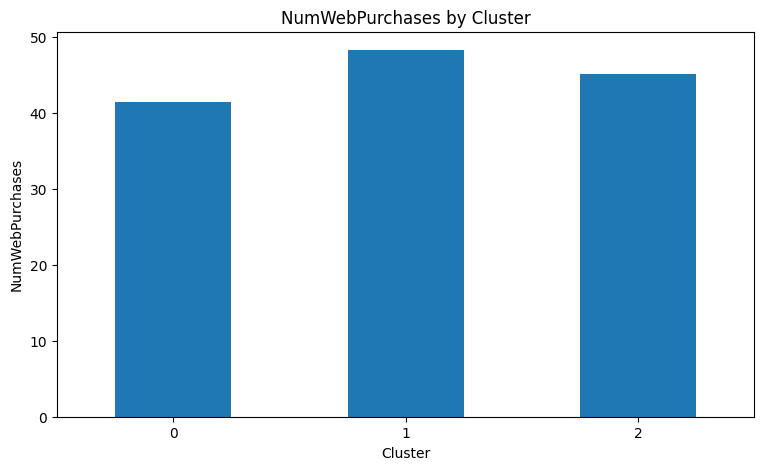

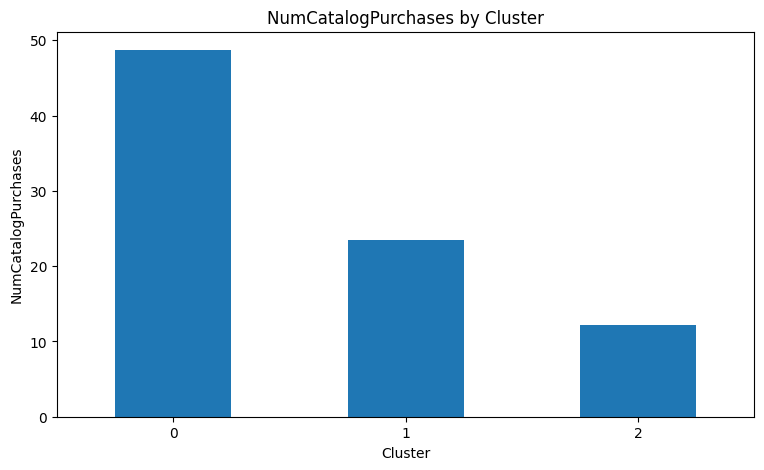

In [ ]:
for col in segment_summary_purchase_without_store.columns:
    plt.figure(figsize=(9, 5))
    segment_summary_purchase_without_store[col].plot(kind='bar')
    plt.xlabel('Cluster')
    plt.ylabel(col)
    plt.title(f'{col} by Cluster')
    plt.xticks(rotation=0)
    plt.show()

Cluster 0 (Haute Valeur / Champions) :

- Canal Préféré à Distance : Ce segment est le plus grand utilisateur du Catalogue (48.71% de ses achats à distance). Leurs achats via le Web sont également importants.

Cluster 1 (Valeur Moyenne / Amateurs de Vin) :

- Canal Préféré à Distance : Ce segment est clairement le plus orienté vers le Web (48.32%).

Cluster 2 (Faible Valeur / Budget) :

- Canal Préféré à Distance : Ce cluster est dominé par les achats via Deals (42.74%).

# Machine Learning - Random Forest

## Création des variables et des fonctionnalités

In [ ]:
df_cluster_encode_scaled['Cluster']=kmean_final.labels_


In [ ]:
y=df_cluster_encode_scaled.Cluster
X=df_cluster_encode_scaled.drop('Cluster', axis=1)

## Diviser les données en données d'entraînement et données de test

In [ ]:
x_train, x_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)
# allocating 80% to training and 20% for testing

## Appliquer la recherche de grille pour trouver les meilleurs paramètres optimaux

In [ ]:
#Définit l'espace de recherche (param_grid) pour l'optimisation des hyperparamètres du modèle Random Forest.
param_grid= {'n_estimators': [100, 200, 3000],
             'max_depth': [10, 20, 30],
             'min_samples_split': [2, 5, 10]}
scorer=make_scorer(f1_score)

In [ ]:

rf_gs=GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, scoring=scorer, cv=5, n_jobs=-1)
rf_gs.fit(x_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 3000]},
             scoring=make_scorer(f1_score, response_method='predict'))

In [ ]:
best_rf_model = rf_gs.best_estimator_
y_pred_rf = best_rf_model.predict(x_test)
f1 = f1_score(y_test, y_pred_rf, average='weighted')

In [ ]:
f1

0.9753802193929468

In [ ]:
final_report = classification_report(y_test, y_pred_rf)
print(final_report)

              precision    recall  f1-score   support

           0       0.99      0.98      0.98        99
           1       0.94      0.97      0.96       111
           2       0.99      0.97      0.98       194

    accuracy                           0.98       404
   macro avg       0.97      0.98      0.97       404
weighted avg       0.98      0.98      0.98       404



In [ ]:
y_pred_proba = best_rf_model.predict_proba(x_test)

In [ ]:
final_auc_score = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
print(f"\nAUC-ROC Score: {final_auc_score:.4f}")


AUC-ROC Score: 0.9973


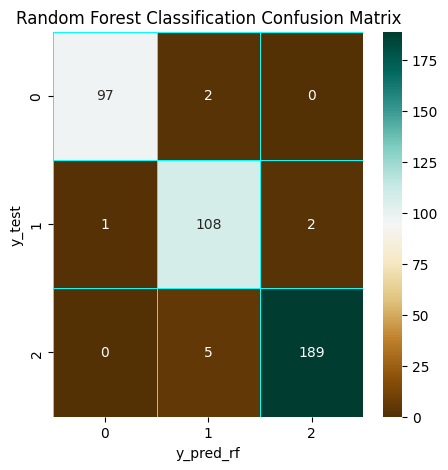

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_rf)

f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot=True, linewidth=0.7, linecolor='cyan', fmt='.0f', ax=ax, cmap='BrBG')
plt.title('Random Forest Classification Confusion Matrix')
plt.xlabel('y_pred_rf')
plt.ylabel('y_test')
plt.show()

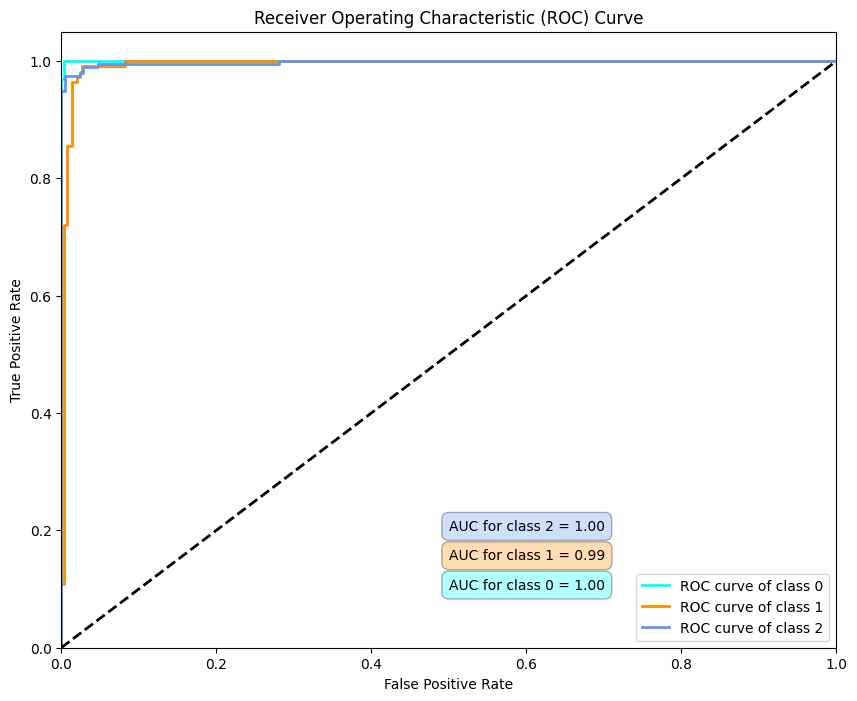

In [ ]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Get the number of classes
n_classes = len(np.unique(y_test))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred_proba[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0}'.format(i)) # Removed AUC from label
    # Add text annotation for AUC
    plt.text(0.5, 0.1 + i * 0.05, 'AUC for class {0} = {1:.2f}'.format(i, roc_auc[i]),
             bbox=dict(boxstyle='round,pad=0.5', fc=color, alpha=0.3), color='black')


plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right") # Keep legend without AUC for clarity
plt.show()

In [ ]:
df.to_csv('df_cluster.csv')